<a href="https://colab.research.google.com/github/mooglol/DS-Unit-2-Regression-Classification/blob/master/module3/assignment_regression_classification_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science, Unit 2: Predictive Modeling

# Regression & Classification, Module 3

## Assignment

We're going back to our other **New York City** real estate dataset. Instead of predicting apartment rents, you'll predict property sales prices.

But not just for condos in Tribeca...

Instead, predict property sales prices for **One Family Dwellings** (`BUILDING_CLASS_CATEGORY` == `'01 ONE FAMILY DWELLINGS'`). 

Use a subset of the data where the **sale price was more than \\$100 thousand and less than $2 million.** 

The [NYC Department of Finance](https://www1.nyc.gov/site/finance/taxes/property-rolling-sales-data.page) has a glossary of property sales terms and NYC Building Class Code Descriptions. The data comes from the [NYC OpenData](https://data.cityofnewyork.us/browse?q=NYC%20calendar%20sales) portal.

- [ ] Do train/test split. Use data from January — March 2019 to train. Use data from April 2019 to test.
- [ ] Do one-hot encoding of categorical features.
- [ ] Do feature selection with `SelectKBest`.
- [ ] Do [feature scaling](https://scikit-learn.org/stable/modules/preprocessing.html).
- [ ] Fit a ridge regression model with multiple features.
- [ ] Get mean absolute error for the test set.
- [ ] As always, commit your notebook to your fork of the GitHub repo.


## Stretch Goals
- [ ] Add your own stretch goal(s) !
- [ ] Instead of `RidgeRegression`, try `LinearRegression`. Depending on how many features you select, your errors will probably blow up! 💥
- [ ] Instead of `RidgeRegression`, try [`RidgeCV`](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.RidgeCV.html).
- [ ] Learn more about feature selection:
    - ["Permutation importance"](https://www.kaggle.com/dansbecker/permutation-importance)
    - [scikit-learn's User Guide for Feature Selection](https://scikit-learn.org/stable/modules/feature_selection.html)
    - [mlxtend](http://rasbt.github.io/mlxtend/) library
    - scikit-learn-contrib libraries: [boruta_py](https://github.com/scikit-learn-contrib/boruta_py) & [stability-selection](https://github.com/scikit-learn-contrib/stability-selection)
    - [_Feature Engineering and Selection_](http://www.feat.engineering/) by Kuhn & Johnson.
- [ ] Try [statsmodels](https://www.statsmodels.org/stable/index.html) if you’re interested in more inferential statistical approach to linear regression and feature selection, looking at p values and 95% confidence intervals for the coefficients.
- [ ] Read [_An Introduction to Statistical Learning_](http://faculty.marshall.usc.edu/gareth-james/ISL/ISLR%20Seventh%20Printing.pdf), Chapters 1-3, for more math & theory, but in an accessible, readable way.
- [ ] Try [scikit-learn pipelines](https://scikit-learn.org/stable/modules/compose.html).

In [1]:
import os, sys
in_colab = 'google.colab' in sys.modules

# If you're in Colab...
if in_colab:
    # Pull files from Github repo
    os.chdir('/content')
    !git init .
    !git remote add origin https://github.com/LambdaSchool/DS-Unit-2-Regression-Classification.git
    !git pull origin master
    
    # Install required python packages
    !pip install -r requirements.txt
    
    # Change into directory for module
    os.chdir('module3')

Initialized empty Git repository in /content/.git/
remote: Enumerating objects: 156, done.
remote: Total 156 (delta 0), reused 0 (delta 0), pack-reused 156
Receiving objects: 100% (156/156), 19.30 MiB | 19.57 MiB/s, done.
Resolving deltas: 100% (71/71), done.
From https://github.com/LambdaSchool/DS-Unit-2-Regression-Classification
 * branch            master     -> FETCH_HEAD
 * [new branch]      master     -> origin/master
     |████████████████████████████████| 92kB 2.4MB/s 
     |████████████████████████████████| 112kB 9.8MB/s 
     |████████████████████████████████| 133kB 22.0MB/s 
     |████████████████████████████████| 57.7MB 1.3MB/s 
     |████████████████████████████████| 235kB 38.5MB/s 
     |████████████████████████████████| 614kB 39.6MB/s 
     |████████████████████████████████| 235kB 39.6MB/s 
     |████████████████████████████████| 307kB 40.9MB/s 
     |████████████████████████████████| 215kB 37.6MB/s 
     |████████████████████████████████| 51kB 20.2MB/s 
     |██████████

In [0]:
# Ignore this Numpy warning when using Plotly Express:
# FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning, module='numpy')

In [0]:
import pandas as pd
import pandas_profiling

# Read New York City property sales data
df = pd.read_csv('../data/condos/NYC_Citywide_Rolling_Calendar_Sales.csv')

# Change column names: replace spaces with underscores
df.columns = [col.replace(' ', '_') for col in df]

# SALE_PRICE was read as strings.
# Remove symbols, convert to integer
df['SALE_PRICE'] = (
    df['SALE_PRICE']
    .str.replace('$','')
    .str.replace('-','')
    .str.replace(',','')
    .astype(int)
)

In [0]:
# BOROUGH is a numeric column, but arguably should be a categorical feature,
# so convert it from a number to a string
df['BOROUGH'] = df['BOROUGH'].astype(str)

In [0]:
# Reduce cardinality for NEIGHBORHOOD feature

# Get a list of the top 10 neighborhoods
top10 = df['NEIGHBORHOOD'].value_counts()[:10].index

# At locations where the neighborhood is NOT in the top 10, 
# replace the neighborhood with 'OTHER'
df.loc[~df['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'

In [7]:
df.head()

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,EASE-MENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
0,1,OTHER,13 CONDOS - ELEVATOR APARTMENTS,2,716,1246,NaN,R4,"447 WEST 18TH STREET, PH12A",PH12A,10011.0,1.0,0.0,1.0,"10,733",1979.0,2007.0,2,R4,0,01/01/2019
1,1,OTHER,21 OFFICE BUILDINGS,4,812,68,NaN,O5,144 WEST 37TH STREET,NaN,10018.0,0.0,6.0,6.0,"2,962",15435.0,1920.0,4,O5,0,01/01/2019
2,1,OTHER,21 OFFICE BUILDINGS,4,839,69,NaN,O5,40 WEST 38TH STREET,NaN,10018.0,0.0,7.0,7.0,"2,074",11332.0,1930.0,4,O5,0,01/01/2019
3,1,OTHER,13 CONDOS - ELEVATOR APARTMENTS,2,592,1041,NaN,R4,"1 SHERIDAN SQUARE, 8C",8C,10014.0,1.0,0.0,1.0,0,500.0,0.0,2,R4,0,01/01/2019
4,1,UPPER EAST SIDE (59-79),15 CONDOS - 2-10 UNIT RESIDENTIAL,2C,1379,1402,NaN,R1,"20 EAST 65TH STREET, B",B,10065.0,1.0,0.0,1.0,0,6406.0,0.0,2,R1,0,01/01/2019


In [0]:
df1 = df[df.BUILDING_CLASS_CATEGORY	 == '01 ONE FAMILY DWELLINGS']

In [12]:
df1.head()

,BOROUGH,NEIGHBORHOOD,BUILDING_CLASS_CATEGORY,TAX_CLASS_AT_PRESENT,BLOCK,LOT,EASE-MENT,BUILDING_CLASS_AT_PRESENT,ADDRESS,APARTMENT_NUMBER,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,LAND_SQUARE_FEET,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE,BUILDING_CLASS_AT_TIME_OF_SALE,SALE_PRICE,SALE_DATE
7,2,OTHER,01 ONE FAMILY DWELLINGS,1,4090,37,NaN,A1,1193 SACKET AVENUE,NaN,10461.0,1.0,0.0,1.0,"3,404",1328.0,1925.0,1,A1,0,01/01/2019
8,2,OTHER,01 ONE FAMILY DWELLINGS,1,4120,18,NaN,A5,1215 VAN NEST AVENUE,NaN,10461.0,1.0,0.0,1.0,"2,042",1728.0,1935.0,1,A5,0,01/01/2019
9,2,OTHER,01 ONE FAMILY DWELLINGS,1,4120,20,NaN,A5,1211 VAN NEST AVENUE,NaN,10461.0,1.0,0.0,1.0,"2,042",1728.0,1935.0,1,A5,0,01/01/2019
42,3,OTHER,01 ONE FAMILY DWELLINGS,1,6809,54,NaN,A1,2601 AVENUE R,NaN,11229.0,1.0,0.0,1.0,"3,333",1262.0,1925.0,1,A1,0,01/01/2019
44,3,OTHER,01 ONE FAMILY DWELLINGS,1,5495,801,NaN,A9,4832 BAY PARKWAY,NaN,11230.0,1.0,0.0,1.0,"6,800",1325.0,1930.0,1,A9,550000,01/01/2019


In [15]:
df1['SALE_DATE'] = pd.to_datetime(df1['SALE_DATE'])
df1['SALE_DATE'].head()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


7    2019-01-01
8    2019-01-01
9    2019-01-01
42   2019-01-01
44   2019-01-01
Name: SALE_DATE, dtype: datetime64[ns]

In [0]:
train = df1[df1['SALE_DATE'].dt.month <= 3]
test = df1[df1['SALE_DATE'].dt.month == 4]

In [0]:
y_train = train['SALE_PRICE']
y_test = test['SALE_PRICE']

In [18]:
from sklearn.metrics import mean_absolute_error

print('Mean Baseline (using 0 features)')
guess = y_train.mean()

y_pred = [guess] * len(y_train)
mae = mean_absolute_error(y_train, y_pred)
print(f'Train Error: {mae:.2f} dollars')

y_pred = [guess] * len(y_test)
mae = mean_absolute_error(y_test, y_pred)
print(f'Test Error: {mae:.2f} dollars')

Mean Baseline (using 0 features)
Train Error: 379123.15 dollars
Test Error: 399601.36 dollars


In [19]:
train.select_dtypes(include='number').describe().T

,count,mean,std,min,25%,50%,75%,max
BLOCK,4094.0,6665.769419,3911.046025,17.0,3811.00,6026.5,9501.75,16350.0
LOT,4094.0,72.974841,152.843450,1.0,20.25,42.0,69.00,2720.0
EASE-MENT,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
ZIP_CODE,4094.0,11012.498534,516.706900,0.0,10453.00,11234.0,11413.00,11697.0
RESIDENTIAL_UNITS,4094.0,0.991451,0.092076,0.0,1.00,1.0,1.00,1.0
COMMERCIAL_UNITS,4094.0,0.024670,0.159792,0.0,0.00,0.0,0.00,2.0
TOTAL_UNITS,4094.0,1.016121,0.185562,0.0,1.00,1.0,1.00,3.0
GROSS_SQUARE_FEET,4094.0,1571.044944,754.804640,0.0,1170.00,1408.0,1785.75,12618.0
YEAR_BUILT,4094.0,1943.012702,40.361466,0.0,1925.00,1940.0,1955.00,2018.0
TAX_CLASS_AT_TIME_OF_SALE,4094.0,1.000000,0.000000,1.0,1.00,1.0,1.00,1.0


In [20]:
train.select_dtypes(exclude='number').describe().T.sort_values(by='unique')

,count,unique,top,freq,first,last
BUILDING_CLASS_CATEGORY,4094,1,01 ONE FAMILY DWELLINGS,4094,NaN,NaN
APARTMENT_NUMBER,2,2,RP.,1,NaN,NaN
TAX_CLASS_AT_PRESENT,4094,3,1,4058,NaN,NaN
BOROUGH,4094,5,4,1993,NaN,NaN
NEIGHBORHOOD,4094,9,OTHER,3826,NaN,NaN
BUILDING_CLASS_AT_TIME_OF_SALE,4094,12,A1,1543,NaN,NaN
BUILDING_CLASS_AT_PRESENT,4094,15,A1,1542,NaN,NaN
SALE_DATE,4094,90,2019-03-29 00:00:00,96,2019-01-01 00:00:00,2019-03-31 00:00:00
LAND_SQUARE_FEET,4094,1280,"4,000",412,NaN,NaN
ADDRESS,4094,4059,277 NICHOLS AVENUE,3,NaN,NaN


In [21]:
train.groupby('BOROUGH')['SALE_PRICE'].mean()

BOROUGH
1    5.607878e+06
2    3.890324e+05
3    5.327102e+05
4    4.055534e+05
5    3.649178e+05
Name: SALE_PRICE, dtype: float64

In [0]:
target = 'SALE_PRICE'
high_cardinality = ['SALE_DATE', 'ADDRESS', 'LAND_SQUARE_FEET', 'BUILDING_CLASS_AT_PRESENT', 'BUILDING_CLASS_AT_TIME_OF_SALE', 'TAX_CLASS_AT_PRESENT', 'BUILDING_CLASS_CATEGORY', 'EASE-MENT', 'APARTMENT_NUMBER']
features = train.columns.drop([target] + high_cardinality)

X_train = train[features]
y_train = train[target]
X_test = test[features]
y_test = test[target]

In [32]:
X_train.head()

,BOROUGH,NEIGHBORHOOD,BLOCK,LOT,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE
7,2,OTHER,4090,37,10461.0,1.0,0.0,1.0,1328.0,1925.0,1
8,2,OTHER,4120,18,10461.0,1.0,0.0,1.0,1728.0,1935.0,1
9,2,OTHER,4120,20,10461.0,1.0,0.0,1.0,1728.0,1935.0,1
42,3,OTHER,6809,54,11229.0,1.0,0.0,1.0,1262.0,1925.0,1
44,3,OTHER,5495,801,11230.0,1.0,0.0,1.0,1325.0,1930.0,1


In [0]:
import category_encoders as ce
encoder = ce.OneHotEncoder(use_cat_names=True)
X_train = encoder.fit_transform(X_train)
X_test = encoder.transform(X_test)

In [34]:
X_train.head()

,BOROUGH_2,BOROUGH_3,BOROUGH_4,BOROUGH_5,BOROUGH_1,NEIGHBORHOOD_OTHER,NEIGHBORHOOD_FLUSHING-NORTH,NEIGHBORHOOD_BOROUGH PARK,NEIGHBORHOOD_UPPER EAST SIDE (59-79),NEIGHBORHOOD_BEDFORD STUYVESANT,NEIGHBORHOOD_FOREST HILLS,NEIGHBORHOOD_ASTORIA,NEIGHBORHOOD_UPPER EAST SIDE (79-96),NEIGHBORHOOD_UPPER WEST SIDE (79-96),BLOCK,LOT,ZIP_CODE,RESIDENTIAL_UNITS,COMMERCIAL_UNITS,TOTAL_UNITS,GROSS_SQUARE_FEET,YEAR_BUILT,TAX_CLASS_AT_TIME_OF_SALE
7,1,0,0,0,0,1,0,0,0,0,0,0,0,0,4090,37,10461.0,1.0,0.0,1.0,1328.0,1925.0,1
8,1,0,0,0,0,1,0,0,0,0,0,0,0,0,4120,18,10461.0,1.0,0.0,1.0,1728.0,1935.0,1
9,1,0,0,0,0,1,0,0,0,0,0,0,0,0,4120,20,10461.0,1.0,0.0,1.0,1728.0,1935.0,1
42,0,1,0,0,0,1,0,0,0,0,0,0,0,0,6809,54,11229.0,1.0,0.0,1.0,1262.0,1925.0,1
44,0,1,0,0,0,1,0,0,0,0,0,0,0,0,5495,801,11230.0,1.0,0.0,1.0,1325.0,1930.0,1


In [35]:
from sklearn.feature_selection import f_regression, SelectKBest

selector = SelectKBest(score_func=f_regression, k=15)

X_train_selected = selector.fit_transform(X_train, y_train)
X_test_selected = selector.transform(X_test)
X_train_selected.shape, X_test_selected.shape

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:299: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:304: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)


((4094, 15), (967, 15))

In [36]:
all_names = X_train.columns
selected_mask = selector.get_support()
selected_names = all_names[selected_mask]
unselected_names = all_names[~selected_mask]

print('Features selected:')
for name in selected_names:
    print(name)
    
print('\n')
print('Features not selected:')
for name in unselected_names:
    print(name)

Features selected:
BOROUGH_3
BOROUGH_4
BOROUGH_5
BOROUGH_1
NEIGHBORHOOD_OTHER
NEIGHBORHOOD_UPPER EAST SIDE (59-79)
NEIGHBORHOOD_FOREST HILLS
NEIGHBORHOOD_UPPER EAST SIDE (79-96)
NEIGHBORHOOD_UPPER WEST SIDE (79-96)
BLOCK
ZIP_CODE
COMMERCIAL_UNITS
TOTAL_UNITS
GROSS_SQUARE_FEET
YEAR_BUILT


Features not selected:
BOROUGH_2
NEIGHBORHOOD_FLUSHING-NORTH
NEIGHBORHOOD_BOROUGH PARK
NEIGHBORHOOD_BEDFORD STUYVESANT
NEIGHBORHOOD_ASTORIA
LOT
RESIDENTIAL_UNITS
TAX_CLASS_AT_TIME_OF_SALE


In [37]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error

for k in range(1, len(X_train.columns)+1):
    
    print(f'{k} features')
    
    selector = SelectKBest(score_func=f_regression, k=k)
    X_train_selected = selector.fit_transform(X_train, y_train)
    X_test_selected = selector.transform(X_test)
    
    model = LinearRegression()
    model.fit(X_train_selected, y_train)
    y_pred = model.predict(X_test_selected)
    
    mae = mean_absolute_error(y_test, y_pred)
    print(f'Test MAE: ${mae:,.0f} \n')

1 features
Test MAE: $389,409 

2 features
Test MAE: $387,725 

3 features
Test MAE: $377,099 

4 features
Test MAE: $375,335 

5 features
Test MAE: $375,820 

6 features
Test MAE: $376,554 

7 features
Test MAE: $376,523 

8 features
Test MAE: $374,122 

9 features
Test MAE: $374,044 

10 features
Test MAE: $373,980 

11 features
Test MAE: $375,025 

12 features
Test MAE: $375,160 

13 features


/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:299: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:304: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:299: RuntimeWarning: divide by zero encountered in

Test MAE: $374,867 

14 features
Test MAE: $374,935 

15 features
Test MAE: $375,001 

16 features
Test MAE: $375,001 

17 features
Test MAE: $375,129 

18 features
Test MAE: $375,129 

19 features
Test MAE: $374,985 

20 features
Test MAE: $375,148 

21 features
Test MAE: $375,579 

22 features
Test MAE: $375,579 

23 features
Test MAE: $375,579 



/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:299: RuntimeWarning: divide by zero encountered in true_divide
  corr /= X_norms
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:304: RuntimeWarning: invalid value encountered in true_divide
  F = corr ** 2 / (1 - corr ** 2) * degrees_of_freedom
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in greater
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:901: RuntimeWarning: invalid value encountered in less
  return (a < x) & (x < b)
/usr/local/lib/python3.6/dist-packages/scipy/stats/_distn_infrastructure.py:1892: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= _a)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:299: RuntimeWarning: divide by zero encountered in

In [40]:
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge
ridge_reg_split = Ridge().fit(X_train, y_train)
mean_squared_error(y_test, ridge_reg_split.predict(X_test))

487519670251.63074

In [41]:
alphas = []
mses = []

for alpha in range(0, 200, 1):
    ridge_reg_split = Ridge(alpha=alpha).fit(X_train, y_train)
    mse = mean_squared_error(y_test, ridge_reg_split.predict(X_test))
    print(alpha, mse)
    alphas.append(alpha)
    mses.append(mse)

0 977621966878.7715
1 487519670251.63074
2 514818947806.8699
3 534794460859.817
4 550139839973.323
5 562480353081.1064
6 572779844604.3551
7 581631635162.344
8 589416820046.2021
9 596389942160.5865
10 602726971370.0507
11 608553274513.1934
12 613960557302.2145
13 619017487936.8408
14 623776567249.9043
15 628278694641.3328
16 632556277230.7578
17 636635393418.4459
18 640537328008.3229
19 644279680716.1848
20 647877179470.4525
21 651342285858.3302
22 654685651889.8298
23 657916468857.4456
24 661042736838.1425
25 664071475112.3992
26 667008888092.8812
27 669860497395.565
28 672631247889.7754
29 675325593564.295
30 677947567600.7896
31 680500839988.8557
32 682988765236.5972
33 685414422149.0455
34 687780647209.4094
35 690090062766.612
36 692345100979.2208
37 694548024270.8617
38 696700942901.0176
39 698805830137.1292
40 700864535421.236
41 702878795851.1777
42 704850246238.1744
43 706780427956.0902
44 708670796760.3175
45 710522729724.0347
46 712337531415.0969
47 714116439416.8486
48 71586

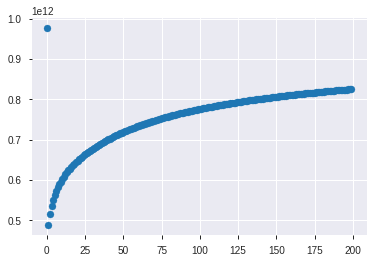

In [42]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.scatter(alphas, mses);

In [47]:
from sklearn.metrics import mean_absolute_error
mean_absolute_error(y_test, ridge_reg_split.predict(X_test))

400086.54481282126